# Binary classification of MRI images
#### AUTHOR: TOMASZ SACHANOWSKI

In [1]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
train_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/train_set/'
test_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/test_set/'
output_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/aug/'
model_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_8'
classes = ["orginal", "generated"]

## Characteristics of the images:
1) Two classes of objects with and without artifacts  
2) several planes of the brain's image  
3) Images with dimensions of 256x256 in a grayscale

## GOAL
#### The goal is to successfully classify images. We would like to correctly indicate the images with the artifacts.

## Number of images available

In [3]:
len(os.listdir(test_dir+classes[0])), len(os.listdir(test_dir+classes[1]))

(75, 85)

In [4]:
len(os.listdir(train_dir+classes[0])), len(os.listdir(train_dir+classes[1]))

(722, 790)

## Data augmentation

In [5]:
gen_parameters = {
    "rotation_range":30,
    "zoom_range":0.2,
    "horizontal_flip":True,
    "vertical_flip":True,
}

In [6]:
flow_parameters ={
    "target_size":(256, 256),
    "color_mode":'grayscale',
    "class_mode":'binary',
    "batch_size":32,
}

In [7]:
# create Image generator for training and test set.
data_gen_train_val = ImageDataGenerator(**gen_parameters, validation_split=0.1)
data_gen_test = ImageDataGenerator(**gen_parameters)

In [8]:
train_generator = data_gen_train_val.flow_from_directory(
    train_dir, subset='training', **flow_parameters)

Found 1361 images belonging to 2 classes.


In [9]:
validation_generator = data_gen_train_val.flow_from_directory(
    train_dir, subset='validation', **flow_parameters)

Found 151 images belonging to 2 classes.


In [10]:
test_generator = data_gen_test.flow_from_directory(
    test_dir, **flow_parameters,
    save_to_dir=output_dir,
    save_format='png'
)

Found 160 images belonging to 2 classes.


In [11]:
class_names = train_generator.class_indices
class_names

{'generated': 0, 'orginal': 1}

## Presentation of images

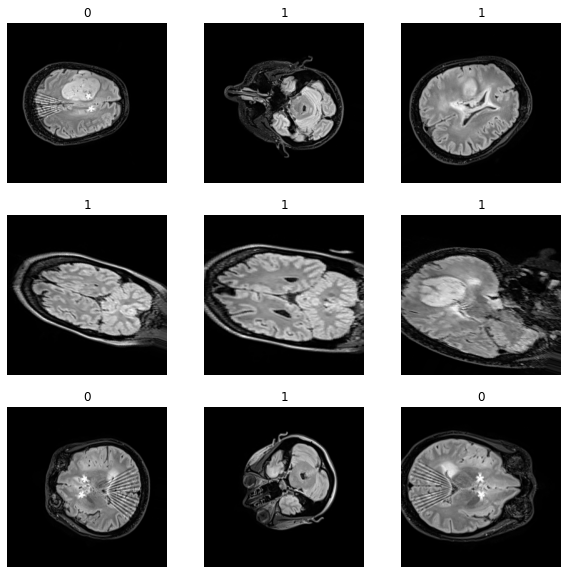

In [13]:
#%matplotlib notebook
plt.figure(figsize=(10, 10))
images, labels = train_generator.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"), cmap='gray')
    plt.title(int(labels[i]))
    plt.axis("off")

## Build the convolutional neural network
### Here is where the convolution, pooling, and flattening layers will be applied
### `Conv2D` layer. It’s defined with the following parameters:
1) 32 output filters,  
2) 3 by 3 feature detector   
3) the `relu` activation function so as to achieve non-linearity 

### `MaxPooling2D` layer defined with the following parameters:
1) `pool_size` of (2, 2) that defines the size of the pooling window  

### That is followed by the `Flatten` layer whose results are passed to the `Dense` layer. The final layer has 1 units because the dataset has 2 classes. Since it’s a binary problem, the sigmoid activation function is applied.

### Reduce overfitting with Dropout. In this process, a specified percentage of connections are dropped during the training process

In [ ]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
#     Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
#    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

## Monitoring the validation loss and save the best model

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/checkpoint',
    save_weights_only=False,
    monitor='val_loss', 
    mode='min', # mam loss wiec min
    save_best_only=True)

In [17]:
callbacks = [
             EarlyStopping(patience=5),
             model_checkpoint_callback,
]

## Compiling the model


In [18]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [20]:
history = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=200, callbacks=callbacks)

Epoch 1/200
43/43 [==============================] - 6s 146ms/step - loss: 0.4478 - binary_accuracy: 0.7693 - val_loss: 0.5394 - val_binary_accuracy: 0.7219
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_8\checkpoint\assets
Epoch 2/200
43/43 [==============================] - 6s 131ms/step - loss: 0.2238 - binary_accuracy: 0.9089 - val_loss: 0.2900 - val_binary_accuracy: 0.9139
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_8\checkpoint\assets
Epoch 3/200
43/43 [==============================] - 6s 127ms/step - loss: 0.1070 - binary_accuracy: 0.9596 - val_loss: 0.0786 - val_binary_accuracy: 1.0000
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_8\checkpoint\assets
Epoch 4/200
43/43 [==============================] - 6s 132ms/step - loss: 0.0460 - binary_accuracy: 0.9853 - val_loss: 0.1116 - val_binary_accuracy: 0.9669
Epoch 5/200


##  Visualize a deep learning model 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 64)    0

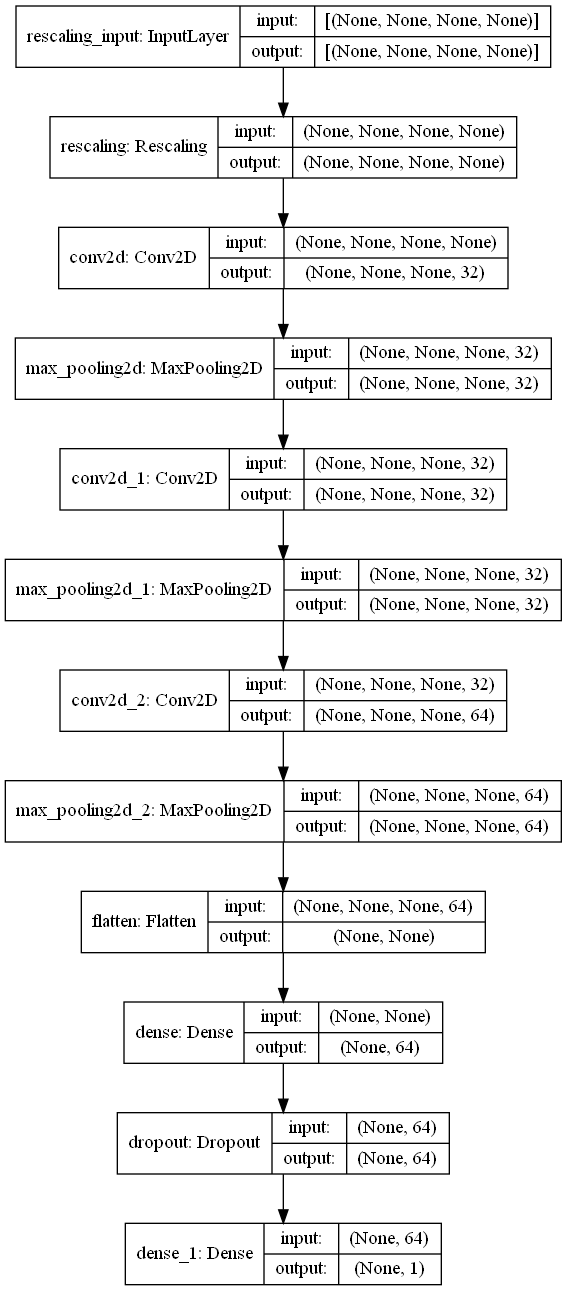

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file=model_dir+ "/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Monitoring the model’s performance


In [23]:
metrics_df = pd.DataFrame(history.history)

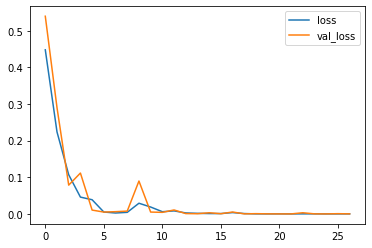

In [24]:
metrics_df[["loss","val_loss"]].plot();

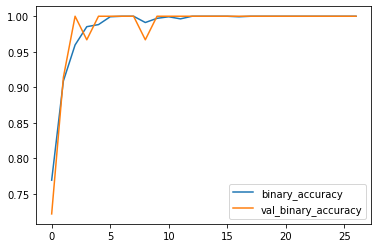

In [25]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

## Checking the performance of the model on the validation set.

In [26]:
loss, accuracy = model.evaluate(validation_generator)

5/5 [==============================] - 1s 84ms/step - loss: 0.0014 - binary_accuracy: 1.0000


In [27]:
print('Accuracy on validation dataset:', accuracy)

Accuracy on val dataset: 1.0


## Checking the model on the test set.

In [32]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 1s 183ms/step - loss: 2.6595e-05 - binary_accuracy: 1.0000
test loss, test acc: [2.6594672817736864e-05, 1.0]


In [85]:
tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5
y_predict = []
y_true = []

for _ in range(250):
    images, labels = test_generator.next()
    class_info = int(labels[0])

    test_image_orginal = np.expand_dims(images[0].astype("uint8"), axis=0)
    prediction = model.predict(test_image_orginal)[0][0]
    y_predict.append(prediction)
    y_true.append(int(labels[0]))
#     print(class_info, prediction)
#     plt.imshow(images[0].astype("uint8"), cmap='gray')
#     plt.show()


    if prediction >= threshold:
        if class_info == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if class_info == 0:
            tn = tn + 1
        else:
            fn = fn + 1

print("True positive: {}\nTrue negative: {}\nFalse Positive: {}\nFalse negative: {}".format(tp, tn, fp, fn))

True positive: 117
True negative: 133
False Positive: 0
False negative: 0


In [86]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predict)

In [87]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

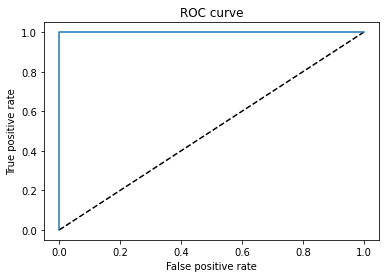

In [88]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

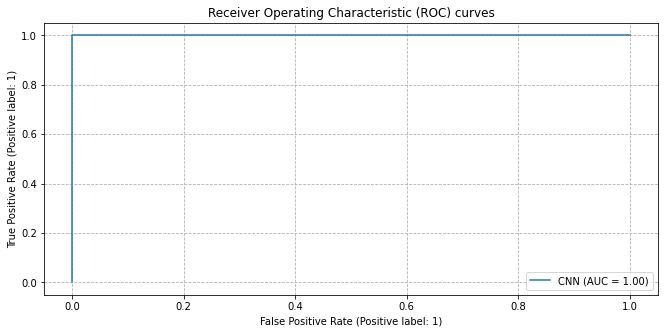

In [92]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split


# prepare plots
fig, ax_roc = plt.subplots(1, 1, figsize=(11, 5))


RocCurveDisplay.from_predictions(y_true, y_predict, ax=ax_roc, name="CNN")
# DetCurveDisplay.from_predictions(y_true, y_predict, ax=ax_det, name="CNN")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
# ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()